#CNN (Convolution Neural Network)
- MNIST


### 1. MNIST
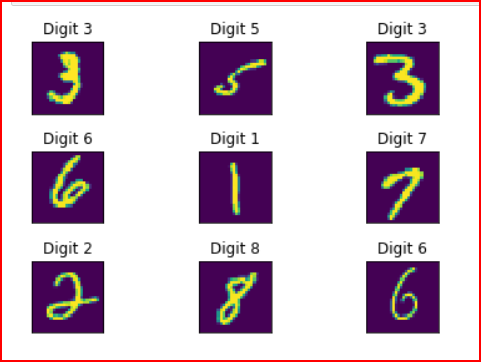

#### 1.0 Define Hyper-parameters

In [1]:
import torch

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjust Model Structure Depends on the Data
num_classes = 10 # label 0~9: total 10 classes
in_channel = 1 # black and white images: 1 channel (RGB: 3 channels)

# Hyper-parameters
batch_size = 10
max_pool_kernel = 2
learning_rate = 0.0001
num_epochs = 3

#### 1.1 Load Data

In [3]:
import torchvision #using torchvision, we can eaily download MNIST dataset
import torchvision.transforms as transforms #to transform MNIST "images" to "tensor"

In [4]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor())

check images

In [5]:
import matplotlib.pyplot as plt

In [6]:
print(test_data[0][0].shape)
print(test_data[0][-1])

torch.Size([1, 28, 28])
7


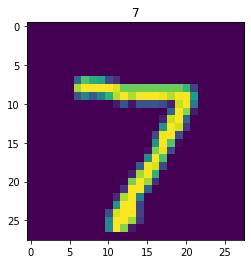

In [7]:
plt.imshow(test_data[0][0].reshape(28,28))
plt.title(test_data[0][-1])
plt.show()

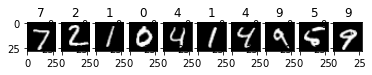

In [8]:
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(test_data[i][0].reshape(28,28), cmap='gray')
  plt.title(test_data[i][-1])

#### 1.2 Define Dataloader

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=True)

#### 1.3 Define Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary #optional, to see model's summary

In [11]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channel, 16, 5, stride=1, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, 5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.fc1 = nn.Linear(7*7*32, 120)
    self.fc2 = nn.Linear(120, num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.reshape(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x))
    return x

In [12]:
model = ConvNet(num_classes).to(device)

In [13]:
# cf) see network form
print(model)

# cf) check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
  print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
                       model summary                        
layer1.0.weight                  torch.Size([16, 1, 5, 5])   
layer1.0.bias                         torch.Size([16])       
layer1.1.weight                       torch.Size([16])       
layer1.1.bias                      

#### 1.4 Set Loss $ Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### 1.5 Train / Test

In [15]:
total_step = len(train_loader)
loss_list = []

# Train
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Assign Tensors to Configured Device
    images = images.to(device)
    labels = labels.to(device)

    # Forward Propagation
    outputs = model(images)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss)

    # Print Loss for Tracking Training
    if (i+1) % 2000 == 0:
      acc = 0
      test_image, test_label = next(iter(test_loader))
      _, test_predicted = torch.max(model(test_image.to(device)).data, 1)

      for (pred, ans) in zip(test_predicted, test_label):
        if pred == ans:
          acc += 1
      acc = acc / len(test_predicted)

      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.1f}%'.format(epoch+1,num_epochs, i+1, total_step, loss.item(), acc*100))
      print('Testing data: [Predicted: {} / Real: {}]'.format(test_predicted, test_label))

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'model.pth')
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/3], Step [2000/6000], Loss: 1.4637, Accuracy: 90.0%
Testing data: [Predicted: tensor([1, 3, 0, 2, 9, 4, 7, 0, 8, 0], device='cuda:0') / Real: tensor([1, 3, 0, 2, 7, 4, 7, 0, 8, 0])]
Epoch [1/3], Step [4000/6000], Loss: 1.5287, Accuracy: 100.0%
Testing data: [Predicted: tensor([3, 6, 3, 1, 8, 8, 8, 5, 8, 8], device='cuda:0') / Real: tensor([3, 6, 3, 1, 8, 8, 8, 5, 8, 8])]
Epoch [1/3], Step [6000/6000], Loss: 1.4656, Accuracy: 100.0%
Testing data: [Predicted: tensor([3, 0, 0, 2, 0, 7, 5, 4, 1, 8], device='cuda:0') / Real: tensor([3, 0, 0, 2, 0, 7, 5, 4, 1, 8])]
Epoch [2/3], Step [2000/6000], Loss: 1.4707, Accuracy: 100.0%
Testing data: [Predicted: tensor([8, 0, 6, 4, 1, 7, 1, 8, 2, 4], device='cuda:0') / Real: tensor([8, 0, 6, 4, 1, 7, 1, 8, 2, 4])]
Epoch [2/3], Step [4000/6000], Loss: 1.4620, Accuracy: 100.0%
Testing data: [Predicted: tensor([6, 0, 8, 4, 3, 9, 8, 8, 1, 5], device='cuda:0') / Real: tensor([6, 0, 8, 4, 3, 9, 8, 8, 1, 5])]
Epoch [2/3], Step [6000/6000], Loss: 1.56

In [16]:
# Test after training is done
model.eval() # Set model as evaluation mode (instead of mini-batch mean/var, batchnorm is used)
with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(test_loader)*batch_size, 100*correct/total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images 98.71%


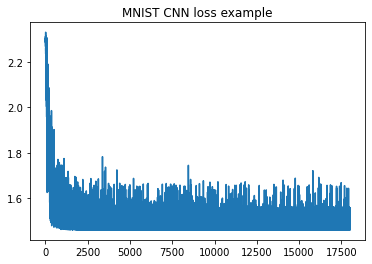

In [18]:
plt.plot(loss_list)
plt.title("MNIST CNN loss example")
plt.show()